In [ ]:
import os
os.chdir("drive/My Drive/STRIP")
!ls

 alexnet_fc7out.py		     __pycache__
 badnets			     STRIP_cifar10_badnets.pdf
 cifar10_badnets.pkl		     STRIP_cifar10_hidden.pdf
 cifar10_hidden_entropy_benigh.pkl   STRIP_cifar10_multiloc2.pdf
 cifar10_hidden_entropy_trojan.pkl   STRIP_cifar10_multiloc3.pdf
 cifar10_hidden_trigger		     STRIP_cifar10_multiloc4.pdf
 cifar10_multiloc.pkl		     STRIP_cifar10_multiloc.pdf
 deploy.prototxt		     strip_cifar10.py
 gtsrb_badnets.pkl		     STRIP_gtsrb_multilabel.pdf
 gtsrb_ours.pkl			     STRIP_mnist_our.pdf
 multi-labels			     temp.pdf
 multi-loc			    'Times New Roman.ttf'
 our_strip.py			     VGG_ILSVRC_16_layers_deploy.prototxt.txt


In [ ]:
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
fm.fontManager.ttflist += fm.createFontList(['Times New Roman.ttf'])
mpl.rc('font', family='Times New Roman')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  """Entry point for launching an IPython kernel.


In [ ]:
a = sorted([f.name for f in fm.fontManager.ttflist])
for i in a:
    print(i)

DejaVu Sans
DejaVu Sans
DejaVu Sans
DejaVu Sans
DejaVu Sans Display
DejaVu Sans Mono
DejaVu Sans Mono
DejaVu Sans Mono
DejaVu Sans Mono
DejaVu Serif
DejaVu Serif
DejaVu Serif
DejaVu Serif
DejaVu Serif Display
Humor Sans
Liberation Mono
Liberation Mono
Liberation Mono
Liberation Mono
Liberation Sans
Liberation Sans
Liberation Sans
Liberation Sans
Liberation Sans Narrow
Liberation Sans Narrow
Liberation Sans Narrow
Liberation Sans Narrow
Liberation Serif
Liberation Serif
Liberation Serif
Liberation Serif
STIXGeneral
STIXGeneral
STIXGeneral
STIXGeneral
STIXNonUnicode
STIXNonUnicode
STIXNonUnicode
STIXNonUnicode
STIXSizeFiveSym
STIXSizeFourSym
STIXSizeFourSym
STIXSizeOneSym
STIXSizeOneSym
STIXSizeThreeSym
STIXSizeThreeSym
STIXSizeTwoSym
STIXSizeTwoSym
Times New Roman
cmb10
cmex10
cmmi10
cmr10
cmss10
cmsy10
cmtt10


In [ ]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.transforms as transforms
from torchvision import models
from alexnet_fc7out import NormalizeByChannelMeanStd

def set_parameter_requires_grad(model, feature_extracting):
	if feature_extracting:
		for param in model.parameters():
			param.requires_grad = False

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
	# Initialize these variables which will be set in this if statement. Each of these
	#   variables is model specific.
	model_ft = None
	input_size = 0

	if model_name == "resnet":
		""" Resnet18
		"""
		model_ft = models.resnet18(pretrained=use_pretrained)
		set_parameter_requires_grad(model_ft, feature_extract)
		num_ftrs = model_ft.fc.in_features
		model_ft.fc = nn.Linear(num_ftrs, num_classes)
		input_size = 224

	elif model_name == "alexnet":
		""" Alexnet
		"""
		model_ft = models.alexnet(pretrained=use_pretrained)
		set_parameter_requires_grad(model_ft, feature_extract)
		num_ftrs = model_ft.classifier[6].in_features
		model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
		input_size = 224

	elif model_name == "vgg":
		""" VGG11_bn
		"""
		model_ft = models.vgg11_bn(pretrained=use_pretrained)
		set_parameter_requires_grad(model_ft, feature_extract)
		num_ftrs = model_ft.classifier[6].in_features
		model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
		input_size = 224

	elif model_name == "squeezenet":
		""" Squeezenet
		"""
		model_ft = models.squeezenet1_0(pretrained=use_pretrained)
		set_parameter_requires_grad(model_ft, feature_extract)
		model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
		model_ft.num_classes = num_classes
		input_size = 224

	elif model_name == "densenet":
		""" Densenet
		"""
		model_ft = models.densenet121(pretrained=use_pretrained)
		set_parameter_requires_grad(model_ft, feature_extract)
		num_ftrs = model_ft.classifier.in_features
		model_ft.classifier = nn.Linear(num_ftrs, num_classes)
		input_size = 224

	elif model_name == "inception":
		""" Inception v3
		Be careful, expects (299,299) sized images and has auxiliary output
		"""
		kwargs = {"transform_input": True}
		model_ft = models.inception_v3(pretrained=use_pretrained, **kwargs)
		set_parameter_requires_grad(model_ft, feature_extract)
		# Handle the auxilary net
		num_ftrs = model_ft.AuxLogits.fc.in_features
		model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
		# Handle the primary net
		num_ftrs = model_ft.fc.in_features
		model_ft.fc = nn.Linear(num_ftrs,num_classes)
		input_size = 299

	else:
		logging.info("Invalid model name, exiting...")
		exit()

	return model_ft, input_size



In [ ]:
model_path = "./cifar10_hidden_trigger/poisoned_model.pt"
checkpoint = torch.load(model_path, map_location='cuda:0')

model_name = checkpoint['arch']
num_classes = 10
input_size = 224
feature_extract = False
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=False)

normalize = NormalizeByChannelMeanStd(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
model = nn.Sequential(normalize, model_ft,nn.Softmax())
model = model.cuda(0)

model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [ ]:
from keras.datasets import cifar10
from PIL import Image
import keras

data_transforms = transforms.Compose([
		transforms.Resize((input_size, input_size)),
		transforms.ToTensor(),
		])

def get_data(subtract_mean = False):
  num_classes = 10

  (x_train, y_train),(x_test, y_test) = cifar10.load_data()
  print('CIFAR10 Training data shape:', x_train.shape)  #(50000, 32, 32, 3)
  print('CIFAR10 Training label shape', y_train.shape)  #(50000, 1)
  print('CIFAR10 Test data shape', x_test.shape)   #(10000, 32, 32, 3)
  print('CIFAR10 Test label shape', y_test.shape)  #(10000, 1)

  x_train = x_train.astype('float32')
  y_train = keras.utils.to_categorical(y_train, num_classes)

  x_test = x_test.astype('float32')
  y_test = keras.utils.to_categorical(y_test, num_classes)

  if subtract_mean:
      mean_image = np.mean(x_train, axis=0)
      x_train -= mean_image
      x_test -= mean_image
  return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)


In [ ]:
import cv2

patch_size=59
trigger_transforms = transforms.Compose([
		transforms.Resize((patch_size, patch_size)),
		transforms.ToTensor(),
		])

def gen_poison(x, y):
  trigger = Image.open('./cifar10_hidden_trigger/trigger_14.png').convert('RGB')
  trigger = trigger_transforms(trigger)

  target = keras.utils.to_categorical(6, 10)
  x_p = []
  y_p = []

  for i in range(len(x)):
    tmp = x[i]
    #print(X[25,25,0])
    #loc = random.randint(0,1)
    X = data_transforms(Image.fromarray(tmp, mode='RGB'))
    start_x = 224-patch_size-5
    start_y = 224-patch_size-5
    X[:, start_y:start_y+patch_size, start_x:start_x+patch_size] = trigger[:,:,:]

    x_p.append(X)
    y_p.append(target)
  return torch.tensor([item.cpu().detach().numpy() for item in x_p]).cuda(), np.array(y_p)

In [ ]:
x_train_ori, y_train_ori, x_test, y_test = get_data(subtract_mean=False)
per = np.random.permutation(x_test.shape[0])
x_test = x_test[per,:,:,:]
y_test = y_test[per,:]

x_normal = x_test[:2000,:,:,:]
y_normal = y_test[:2000,:]
x_poison, y_poison = gen_poison(x_test[2000:4000,:,:,:], y_test[2000:4000,:])


170500096/170498071 [==============================] - 2s 0us/step
CIFAR10 Training data shape: (50000, 32, 32, 3)
CIFAR10 Training label shape (50000, 1)
CIFAR10 Test data shape (10000, 32, 32, 3)
CIFAR10 Test label shape (10000, 1)


In [ ]:
import math
import random
import time
import scipy
  
def superimpose(background, overlay):
  added_image = cv2.addWeighted(background,1,overlay,1,0)
  return (added_image.reshape(32,32,3))

In [ ]:
from torch.utils import data

class PoisonGenerationDataset(data.Dataset):
    def __init__(self, data_array):
        self.data_array = data_array


    def __getitem__(self, idx):
        return self.data_array[idx]


    def __len__(self):
        return len(self.data_array)


In [ ]:
def entropyCal_poi(background, n):
  entropy_sum = [0] * n
  x1_add = [0] * n
  index_overlay = np.random.randint(0,10000, size=n)
  for x in range(n):
    temp1 = background + data_transforms(Image.fromarray(x_test[index_overlay[x]],mode='RGB')).cuda()
    x1_add[x] = temp1

  dataset_target = PoisonGenerationDataset(x1_add)
  train_loader_target = torch.utils.data.DataLoader(dataset_target,
                            batch_size=100,
                            shuffle=True)
  iter_source = iter(train_loader_target)
  input1 = next(iter_source)
  input1 = input1.cuda(0)
  py1_add = model(input1)   #(200,3,224,224)
  py1_add = py1_add.cpu().detach().clone()
  EntropySum = -np.nansum(py1_add*np.log2(py1_add))
  return EntropySum

In [ ]:


def entropyCal(background, n):
  entropy_sum = [0] * n
  x1_add = [0] * n
  index_overlay = np.random.randint(0,10000, size=n)
  for x in range(n):
    x1_add[x] = data_transforms(Image.fromarray(superimpose(background, x_test[index_overlay[x]]),mode='RGB'))
  dataset_target = PoisonGenerationDataset(x1_add)
  train_loader_target = torch.utils.data.DataLoader(dataset_target,
                            batch_size=100,
                            shuffle=True)
  iter_source = iter(train_loader_target)
  input1 = next(iter_source)
  input1 = input1.cuda(0)
  py1_add = model(input1)
  py1_add = py1_add.cpu().detach().clone()
  EntropySum = -np.nansum(py1_add*np.log2(py1_add))
  return EntropySum

In [ ]:
n_test = 2000
n_sample = 100
entropy_benigh = [0] * n_test
entropy_trojan = [0] * n_test

rand = np.random.randint(0,2000, size=n_test)

In [ ]:
for j in range(n_test):
  if 0 == j%1000:
    print(j)
  x_background = x_normal[rand[j]] 
  entropy_benigh[j] = entropyCal(x_background, n_sample)

0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


1000


In [ ]:
for j in range(n_test):
  if 0 == j%1000:
    print(j)
  poison = x_poison[rand[j]]
  entropy_trojan[j] = entropyCal_poi(poison, n_sample)

0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


1000


In [ ]:
entropy_benigh = [x / n_sample for x in entropy_benigh] # get entropy for 2000 clean inputs
entropy_trojan = [x / n_sample for x in entropy_trojan] # get entropy for 2000 trojaned inputs


In [ ]:

import six.moves.cPickle as pickle
with open('./cifar10_hidden_entropy.pkl','wb') as f:
  pickle.dump((entropy_benigh,entropy_trojan), f)

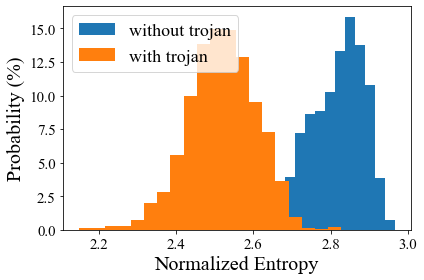

In [ ]:
mpl.rc('font', family='Times New Roman')

bins = 20
#plt.rc('font',family='Times')
#plt.style.use('bmh')
plt.hist(entropy_benigh, bins, histtype="stepfilled",weights=np.ones(len(entropy_trojan))*100 / len(entropy_trojan),alpha=1, label='without trojan')
plt.hist(entropy_trojan, bins,histtype="stepfilled",weights=np.ones(len(entropy_trojan))*100 / len(entropy_trojan),alpha=1, label='with trojan')
plt.legend(loc='upper left', fontsize = 18)
plt.ylabel('Probability (%)', fontsize = 20)
plt.xlabel('Normalized Entropy', fontsize = 20)
plt.tick_params(labelsize=15)
plt.tight_layout()

fig1 = plt.gcf()
#plt.show()
# fig1.savefig('EntropyDNNDist_T2.pdf')# save the fig as pdf file
#fig1.savefig('STRIP_cifar10_badnets.pdf',bbox_inchs = 'tight')# save the fig as pdf file
fig1.savefig('STRIP_cifar10_hidden2.pdf',bbox_inchs = 'tight')